<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200404_mnist/mnist_withGPUtfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

import os, sys
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(tfds.__version__)

2.2.0-rc2
2.1.0


# Import data

In [3]:
(ds_train, ds_dev, ds_test), info = tfds.load('mnist', split=('train[:90%]', 'train[90%:]', 'test')
    , shuffle_files=True, with_info=True, as_supervised=True)
print(info)
n_train, n_dev, n_test = len(list(ds_train)), len(list(ds_dev)), len(list(ds_test))
print('no. of data for train, dev, test', n_train, n_dev, n_test)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

no. of data for train, dev, test 54000 6000 10000


In [0]:
INPUT_SHAPE = info.features['image'].shape
LABEL_NAMES = info.features['label'].names
N_LABELS = info.features['label'].num_classes

Label: 4 Image Max Value: 255


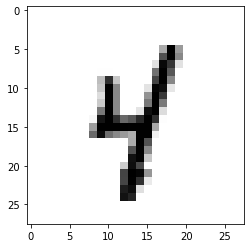

In [5]:
# check data structure
for img, label in ds_train.take(1):
    image = img.numpy().squeeze()
    label = label.numpy()

    print("Label: {}".format(label), "Image Max Value: {}".format(image.max()))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

# Pre-processing

In [0]:
def preprocessor(imgs, labels):
    imgs = tf.cast(imgs, tf.float32)
    imgs /= 255.0
    return imgs, labels

In [0]:
ds_train = ds_train.map(preprocessor).batch(128)
ds_dev = ds_dev.map(preprocessor).batch(128)
ds_test = ds_test.map(preprocessor)

# Modeling

In [0]:
def getModel():
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=INPUT_SHAPE))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2))) 
    model.add(BatchNormalization())
    model.add(Dropout(0.2))       
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))    
    model.add(BatchNormalization())
    model.add(Dropout(0.2))        
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))    
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [0]:
# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [10]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(ds_train, epochs=5, validation_data=ds_dev, verbose=1
                    # , callbacks=[tensorboard_callback]
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3

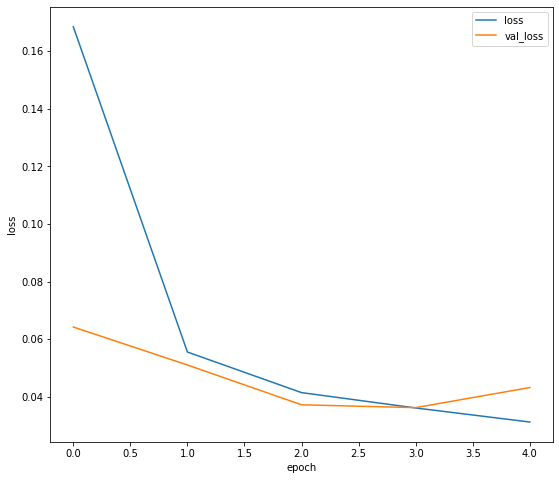

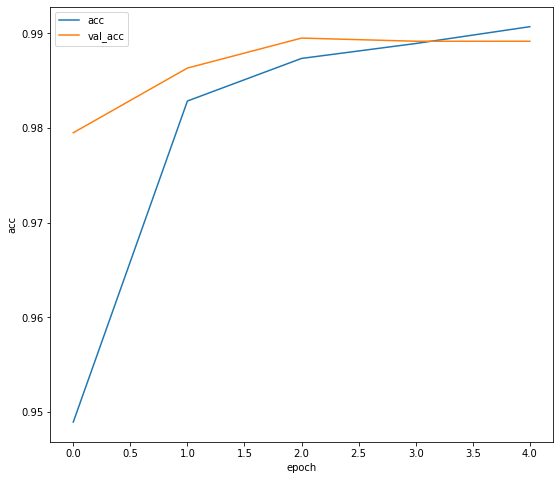

In [11]:
def plot_history(history):
    hist = history.history
    for key in ['loss', 'acc']:
        plt.figure(figsize=(9, 8))
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

%matplotlib inline
plot_history(history)

# Model Evaluation

In [46]:
eval = model.evaluate(ds_test.batch(n_test))
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

1/1 [==============================] - 0s 2ms/step - loss: 0.0306 - acc: 0.9919
Test data: Loss = 0.030584674328565598, Accuracy = 0.9919000267982483
Right Prediction: 9919.000267982483, Wrong Prediction: 80.99973201751709


In [42]:
%%time

test_labels = list(ds_test.batch(n_test))[0][1].numpy()
test_pred = model.predict(ds_test.batch(n_test)).argmax(axis=1)

CPU times: user 4.73 s, sys: 2.37 s, total: 7.1 s
Wall time: 4.08 s


In [44]:
(test_labels==test_pred).sum()

9264

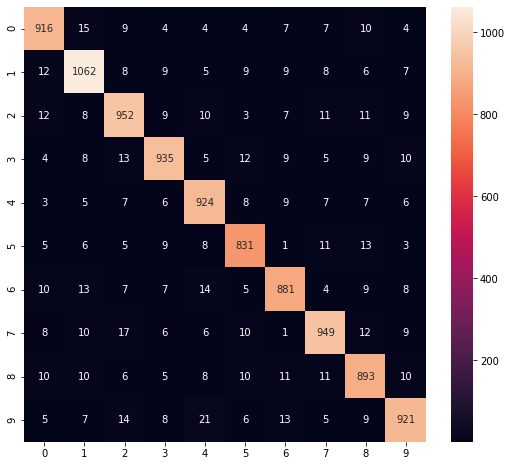

In [45]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(10), range(10)), annot=True, fmt='d')

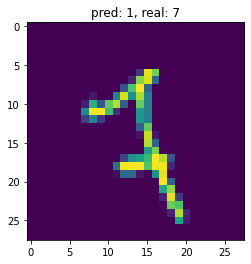

In [15]:
iimg = np.where(test_labels!=test_pred)[0][0]
for img, label in ds_test.skip(iimg).take(1):
    plt.imshow(img.numpy().squeeze() * 255.0)
    plt.title('pred: {}, real: {}'.format(test_pred[iimg],test_labels[iimg]))